In [1]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import sys
sys.path.insert(0, '/Users/tak/Github/QEmbedding/')
import Hybrid_nn
import torch
from torch import nn
import data
import pennylane as qml
import embedding

## 0. Getting Started

This demonstration uses 4 qubits to see how pre-training the quantum embedding can be helpful for training a parameterized QML circuits for classification tasks.

Load the dataset with four features

In [2]:
dev = qml.device('default.qubit', wires=4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_reduction = 'PCA4'
classes = [0,1]
X_train, X_test, Y_train, Y_test = data.data_load_and_process('mnist', '2', feature_reduction=feature_reduction, classes=classes)

def new_data(batch_size, X, Y):
    X1_new, X2_new, Y_new = [], [], []
    for i in range(batch_size):
        n, m = np.random.randint(len(X)), np.random.randint(len(X))
        X1_new.append(X[n])
        X2_new.append(X[m])
        if Y[n] == Y[m]:
            Y_new.append(1)
        else:
            Y_new.append(0)
    return torch.tensor(X1_new).to(device), torch.tensor(X2_new).to(device), torch.tensor(Y_new).to(device)

N_valid, N_test = 500, 10000
X1_new_valid, X2_new_valid, Y_new_valid = new_data(N_valid, X_test, Y_test)
X1_new_test, X2_new_test, Y_new_test = new_data(N_test, X_test, Y_test)

2022-12-14 03:50:00.795125: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-14 03:50:00.796656: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 10. Tune using inter_op_parallelism_threads for best performance.
/opt/anaconda3/envs/QC/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1666646835196/work/torch/csrc/utils/tensor_new.cpp:233.)


Circuit for evaluating Model1_Fidelity and Model1_HSinner for 4 qubits

In [13]:
@qml.qnode(dev, interface="torch")
def Four_circuit(inputs): 
    embedding.Four_QuantumEmbedding(inputs[0:4])
    embedding.Four_QuantumEmbedding_inverse(inputs[4:8])
    return qml.probs(wires=range(4))

# 4 qubit Model1_Fidelity
class Four_Model1_Fidelity(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1 = qml.qnn.TorchLayer(Four_circuit, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack1(x1)
        x2 = self.linear_relu_stack1(x2)
        x = torch.concat([x1, x2], 1)
        x = self.qlayer1(x)
        return x[:,0]

# 4 qubit Model1_HSinner
class Four_Model1_HSinner(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.matrix_fn = qml.matrix(Four_circuit)
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x2):
        x1 = self.linear_relu_stack2(x1)
        x2 = self.linear_relu_stack2(x2)
        x = torch.concat([x1, x2], 1).to("cpu")
        x = [torch.real(torch.trace(self.matrix_fn2(a))) for a in x]
        x = torch.stack(x, dim=0).to(device)
        return x / 2**8


In [14]:
def train_models(model_name):
    train_loss = []
    if model_name == 'Model1_Fidelity':
        model = Four_Model1_Fidelity().to(device)
        PATH = '/Users/tak/Desktop/Four_Model1_Fidelity.pt'
    elif model_name == 'Model1_HSinner':
        PATH = '/Users/tak/Desktop/Four_Model_HSinner.pt'
        model = Four_Model1_HSinner().to(device)
    model.train()

    loss_fn = torch.nn.MSELoss()
    opt = torch.optim.SGD(model.parameters(), lr=0.01)
    for it in range(1000):
        X1_batch, X2_batch, Y_batch = new_data(25, X_train, Y_train)
        X1_batch, X2_batch, Y_batch = X1_batch.to(device), X2_batch.to(device), Y_batch.to(device)

        pred = model(X1_batch, X2_batch)
        pred, Y_batch = pred.to(torch.float32), Y_batch.to(torch.float32)
        loss = loss_fn(pred, Y_batch)
        train_loss.append(loss.item())

        opt.zero_grad()
        loss.backward()
        opt.step()

        if it % 10 == 0:
            print(f"Iterations: {it} Loss: {loss.item()}")
    
    torch.save(model.state_dict(), PATH)


train_models('Model1_Fidelity')
train_models('Model1_HSinner')

Iterations: 0 Loss: 0.3196856379508972
Iterations: 10 Loss: 0.35417670011520386
Iterations: 20 Loss: 0.2789049446582794
Iterations: 30 Loss: 0.1485680788755417
Iterations: 40 Loss: 0.2262270152568817
Iterations: 50 Loss: 0.14342373609542847
Iterations: 60 Loss: 0.07770176231861115
Iterations: 70 Loss: 0.05740072578191757
Iterations: 80 Loss: 0.07181244343519211
Iterations: 90 Loss: 0.1406722217798233
Iterations: 100 Loss: 0.04671367630362511
Iterations: 110 Loss: 0.10723506659269333
Iterations: 120 Loss: 0.10753396898508072
Iterations: 130 Loss: 0.01700788177549839
Iterations: 140 Loss: 0.06290151923894882
Iterations: 150 Loss: 0.04254207760095596
Iterations: 160 Loss: 0.05571345239877701
Iterations: 170 Loss: 0.03364403545856476
Iterations: 180 Loss: 0.07522899657487869
Iterations: 190 Loss: 0.05437304452061653
Iterations: 200 Loss: 0.012980270199477673
Iterations: 210 Loss: 0.07581982761621475
Iterations: 220 Loss: 0.018740080296993256
Iterations: 230 Loss: 0.09658483415842056
Iterat

Calculate the distances of Test dataset with the pre-trained quantum embeddings. From the calculated trace distance gain the lower bound of the linear loss function (with respect to the test data).

In [15]:
X1_test, X0_test = [], []
for i in range(len(X_test)):
    if Y_test[i] == 1:
        X1_test.append(X_test[i])
    else:
        X0_test.append(X_test[i])
X1_test, X0_test = torch.tensor(X1_test), torch.tensor(X0_test)

@qml.qnode(dev, interface="torch")
def Four_Distance(inputs): 
    embedding.Four_QuantumEmbedding(inputs[0:4])
    return qml.density_matrix(wires=range(4))

class Distances(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.qlayer1_distance = qml.qnn.TorchLayer(Four_Distance, weight_shapes={})
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x1, x0, Distance, Trained):
        if Trained:
            x1 = self.linear_relu_stack1(x1)
            x0 = self.linear_relu_stack1(x0)
        rhos1 = self.qlayer1_distance(x1)
        rhos0 = self.qlayer1_distance(x0)
        rho1 = torch.sum(rhos1, dim=0) / len(x1)
        rho0 = torch.sum(rhos0, dim=0) / len(x0)
        rho_diff = rho1 - rho0
        if Distance == 'Trace':
            eigvals = torch.linalg.eigvals(rho_diff)
            return 0.5 * torch.real(torch.sum(torch.abs(eigvals)))
        elif Distance == 'Hilbert-Schmidt':
            return 0.5 * torch.trace(rho_diff @ rho_diff)

PATH = '/Users/tak/Desktop/Four_Model.pt'
Model = Distances()
Model.load_state_dict(torch.load(PATH, map_location='cpu'))

Trace_before, Trace_after = Model(X1_test, X0_test, 'Trace', False), Model(X1_test, X0_test, 'Trace', True)
Lower_bound_before, Lower_bound_after = 0.5 * (1 - Trace_before), 0.5 * (1 - Trace_after)
print(f"Trace Distance Before: {Trace_before}")
print(f"Trace Distance After: {Trace_after}")

print(f"Hilbert-Schmidt Distance Before: {Model(X1_test, X0_test, 'Hilbert-Schmidt', False)}")
print(f"Hilbert-Schmidt Distance After: {Model(X1_test, X0_test, 'Hilbert-Schmidt', True)}")

Trace Distance Before: 0.2723434269428253
Trace Distance After: 0.9160667061805725
Hilbert-Schmidt Distance Before: 0.015371248126029968
Hilbert-Schmidt Distance After: 0.44246774911880493


## Training the parameterized QML circuit with pre-trained Qembedding

In [16]:
Y_train = [-1 if y == 0 else 1 for y in Y_train]
Y_test = [-1 if y == 0 else 1 for y in Y_test]

In [17]:
class x_transform(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack1 = nn.Sequential(
            nn.Linear(4, 6),
            nn.ReLU(),
            nn.Linear(6, 6),
            nn.ReLU(),
            nn.Linear(6, 4)
        )
    def forward(self, x):
        x = self.linear_relu_stack1(x)
        return x.detach().numpy()

PATH = '/Users/tak/Desktop/Four_Model.pt'
model = x_transform()
model.load_state_dict(torch.load(PATH, map_location='cpu'))

<All keys matched successfully>

In [19]:
def statepreparation(x, Trained):
    if Trained:
        x = model(torch.tensor(x))
    embedding.Four_QuantumEmbedding(x)

def U(params, wires): # 15 params
    qml.U3(params[0], params[1], params[2], wires=wires[0])
    qml.U3(params[3], params[4], params[5], wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RY(params[6], wires=wires[0])
    qml.RZ(params[7], wires=wires[1])
    qml.CNOT(wires=[wires[1], wires[0]])
    qml.RY(params[8], wires=wires[0])
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.U3(params[9], params[10], params[11], wires=wires[0])
    qml.U3(params[12], params[13], params[14], wires=wires[1])

def QCNN_four(params):
    param1 = params[0:15]
    param2 = params[15:30]
    U(param1, wires=[0, 1])
    U(param1, wires=[2, 3])
    U(param1, wires=[1, 2])
    U(param1, wires=[3, 0])
    U(param2, wires=[0, 2])


@qml.qnode(dev)
def QCNN_classifier(params, x, Trained):
    statepreparation(x, Trained)
    QCNN_four(params)
    return qml.expval(qml.PauliZ(2))

def Linear_Loss(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += 0.5 * (1 - l * p)
    return loss / len(labels)

def MSE(labels, predictions):
    loss = 0
    for l,p in zip(labels, predictions):
        loss += (l - p) ** 2
    return loss /len(labels)

def cost(weights, X_batch, Y_batch, Trained):
    preds = [QCNN_classifier(weights, x, Trained) for x in X_batch]
    return Linear_Loss(Y_batch, preds)

steps = 1000
learning_rate = 0.01
batch_size = 128
def circuit_training(X_train, Y_train, Trained):

    weights = np.random.random(30, requires_grad = True)
    opt = qml.NesterovMomentumOptimizer(stepsize=learning_rate)
    loss_history = []
    for it in range(steps):
        batch_index = np.random.randint(0, len(X_train), (batch_size,))
        X_batch = [X_train[i] for i in batch_index]
        Y_batch = [Y_train[i] for i in batch_index]
        weights, cost_new = opt.step_and_cost(lambda v: cost(v, X_batch, Y_batch, Trained),
                                                     weights)
        loss_history.append(cost_new)
        if it % 50 == 0:
            print("iteration: ", it, " cost: ", cost_new)
    return loss_history

In [20]:
loss_not_trained = circuit_training(X_train, Y_train, False)

/opt/anaconda3/envs/QC/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:698: ComplexWarning: Casting complex values to real discards the imaginary part
  onp.add.at(A, idx, x)


iteration:  0  cost:  0.5240760854548071
iteration:  50  cost:  0.2716026752635329
iteration:  100  cost:  0.2799796536735786
iteration:  150  cost:  0.34218812082939465
iteration:  200  cost:  0.35754338895151894
iteration:  250  cost:  0.29376394783438003
iteration:  300  cost:  0.3817590171615612
iteration:  350  cost:  0.27338006797432707
iteration:  400  cost:  0.2752961711644244
iteration:  450  cost:  0.2888833508652435
iteration:  500  cost:  0.3283566319247411
iteration:  550  cost:  0.2863273809121731
iteration:  600  cost:  0.27549537940057633
iteration:  650  cost:  0.26774865025804195
iteration:  700  cost:  0.28248746270730996
iteration:  750  cost:  0.24842049184324658
iteration:  800  cost:  0.2329384642754041
iteration:  850  cost:  0.24769564852773104
iteration:  900  cost:  0.20976485281600993
iteration:  950  cost:  0.15635648924943088


In [21]:
loss_trained = circuit_training(X_train, Y_train, True)

iteration:  0  cost:  0.35752491065569525
iteration:  50  cost:  0.14955490656018264
iteration:  100  cost:  0.13733862080892295
iteration:  150  cost:  0.11628187502458821
iteration:  200  cost:  0.09289346560239613
iteration:  250  cost:  0.08873679909651225
iteration:  300  cost:  0.08760119189678607
iteration:  350  cost:  0.08065063769230348
iteration:  400  cost:  0.0797657430198452
iteration:  450  cost:  0.07698784343097681
iteration:  500  cost:  0.07673484067354532
iteration:  550  cost:  0.07487561227720055
iteration:  600  cost:  0.08140501882625274
iteration:  650  cost:  0.07393841649547793
iteration:  700  cost:  0.06914023923203186
iteration:  750  cost:  0.06701271317859141
iteration:  800  cost:  0.06463509522112754
iteration:  850  cost:  0.07642669890701588
iteration:  900  cost:  0.06658438099692897
iteration:  950  cost:  0.06519833180791959


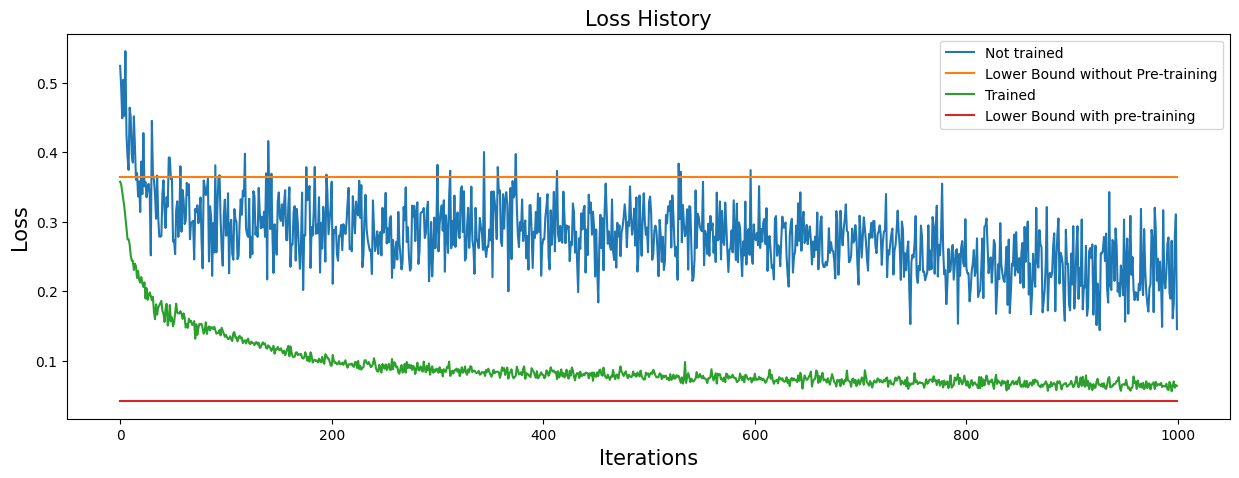

In [29]:

Lower_bound_before, Lower_bound_after = 0.5 * (1 - Trace_before).detach().numpy(), 0.5 * (1 - Trace_after).detach().numpy()
plt.rcParams['figure.figsize'] = [15, 5]
fig, ax1 = plt.subplots()
ax1.plot(range(len(loss_not_trained)), loss_not_trained, label="Not trained")
ax1.plot(range(len(loss_not_trained)), np.ones(1000)*Lower_bound_before, label="Lower Bound without Pre-training")
ax1.plot(range(len(loss_trained)), loss_trained, label="Trained")
ax1.plot(range(len(loss_trained)), np.ones(1000)*Lower_bound_after, label="Lower Bound with pre-training")

ax1.set_title("Loss History").set_fontsize(15)
ax1.set_ylabel("Loss").set_fontsize(15)
ax1.set_xlabel("Iterations").set_fontsize(15)
ax1.legend()
